In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D

import torch.nn.functional as F
import torch.optim as optim

from tqdm import tqdm
from sklearn import datasets

In [3]:
device = torch.device("cpu")

## 2D regression dataset

In [4]:
num_points = 100
# X1 = np.linspace(-2.5, 1.9, num_points)
X1 = np.linspace(-2.5, 2.5, num_points)
X2 = np.linspace(-2.5, 3, num_points)
# X2 = np.linspace(-2.2, 2.1, num_points)
X1, X2 = np.meshgrid(X1, X2)

Y = np.sin(np.sqrt(X1**2 + X2**2))*2-1. - 0.1*(X1)+0.02*(X2)
# Y = np.sqrt(X1**2 + X2**2)

####Scaling the data to range -1,1
X1 = 2*(X1 - X1.min())/(X1.max() - X1.min()) -1
X2 = 2*(X2 - X2.min())/(X2.max() - X2.min()) -1
Y = 2*(Y - Y.min())/(Y.max() - Y.min()) -1

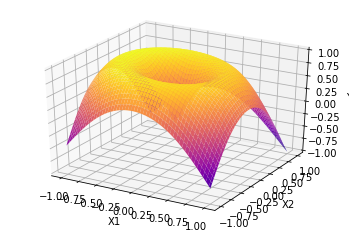

In [5]:
x1 = X1.reshape(-1)
x2 = X2.reshape(-1)
y = Y.reshape(-1)

xx = torch.Tensor(np.c_[x1, x2])
yy = torch.Tensor(Y.reshape(-1,1))

%matplotlib inline
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_surface(X1, X2, Y, cmap='plasma')
ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.set_zlabel('Y')
plt.show()

## Making of Bilinear Layer

In [6]:
class Bilinear(nn.Module):
    def __init__(self, grid_width):
        super().__init__()
        self.grid_width = grid_width
        
        self.W = nn.Linear(2, 2, bias=False)
        
        along_row = torch.linspace(0, 1, self.grid_width).reshape(1, -1)
        along_col = torch.linspace(0, 1, self.grid_width).reshape(-1, 1)
        self.Y = nn.Parameter((along_row+along_col)/2)
        print(self.Y)
        
    def forward(self, x):
        x = self.W(x)+0.5
        
        x = x*self.grid_width
        index = torch.clamp(x.data, 0, self.grid_width-2)
        print(x)
        index = torch.floor(index)
        print(index)
        
        ## x on unit square
        _xy = x-index
        print(_xy)
        
        _xc, _yc = tuple(index.type(torch.long).t())
        print(_xc, _yc)
        print(_xc.unsqueeze(1))
        print(_xc.expand(4, -1).t().view(-1,2,2)+torch.tensor([[0,0],[1,1]]))
        print(_yc.expand(4, -1).t().view(-1,2,2)+torch.tensor([[0,1],[0,1]]))
        
#         print(self.Y[_xc, _yc])
#         print(self.Y[_xc, _yc+1])
        
        _xc = _xc.expand(4, -1).t().view(-1,2,2)+torch.tensor([[0,0],[1,1]])
        _yc = _yc.expand(4, -1).t().view(-1,2,2)+torch.tensor([[0,1],[0,1]])
        mat = self.Y[_xc, _yc]
        print(mat, mat.shape)
        
        _xd = torch.stack([1-_xy[:,0], _xy[:,0]], dim=1).reshape(-1,1,2)
        print(_xd, _xd.shape)
        
        _yd = torch.stack([1-_xy[:,1], _xy[:,1]], dim=1).reshape(-1,2,1)
        print(_yd, _yd.shape)
        ## now bmm
        
        output = torch.bmm(_xd, mat)
        output = torch.bmm(output, _yd)
        print(output.shape)
        
        return output.reshape(-1, 1)

In [7]:
bl = Bilinear(5)

Parameter containing:
tensor([[0.0000, 0.1250, 0.2500, 0.3750, 0.5000],
        [0.1250, 0.2500, 0.3750, 0.5000, 0.6250],
        [0.2500, 0.3750, 0.5000, 0.6250, 0.7500],
        [0.3750, 0.5000, 0.6250, 0.7500, 0.8750],
        [0.5000, 0.6250, 0.7500, 0.8750, 1.0000]], requires_grad=True)


In [8]:
bl(torch.randn(3, 2))

tensor([[ 3.3154,  4.5279],
        [-0.5075, -2.3728],
        [ 5.4533,  6.6487]], grad_fn=<MulBackward0>)
tensor([[3., 3.],
        [0., 0.],
        [3., 3.]])
tensor([[ 0.3154,  1.5279],
        [-0.5075, -2.3728],
        [ 2.4533,  3.6487]], grad_fn=<SubBackward0>)
tensor([3, 0, 3]) tensor([3, 0, 3])
tensor([[3],
        [0],
        [3]])
tensor([[[3, 3],
         [4, 4]],

        [[0, 0],
         [1, 1]],

        [[3, 3],
         [4, 4]]])
tensor([[[3, 4],
         [3, 4]],

        [[0, 1],
         [0, 1]],

        [[3, 4],
         [3, 4]]])
tensor([[[0.7500, 0.8750],
         [0.8750, 1.0000]],

        [[0.0000, 0.1250],
         [0.1250, 0.2500]],

        [[0.7500, 0.8750],
         [0.8750, 1.0000]]], grad_fn=<IndexBackward>) torch.Size([3, 2, 2])
tensor([[[ 0.6846,  0.3154]],

        [[ 1.5075, -0.5075]],

        [[-1.4533,  2.4533]]], grad_fn=<ViewBackward>) torch.Size([3, 1, 2])
tensor([[[-0.5279],
         [ 1.5279]],

        [[ 3.3728],
         [-2.3728]]

tensor([[ 0.9804],
        [-0.3600],
        [ 1.5127]], grad_fn=<ViewBackward>)

In [9]:
### Finalize Here
class Bilinear(nn.Module):
    def __init__(self, grid_width):
        super().__init__()
        self.grid_width = grid_width
        
        self.W = nn.Linear(2, 2, bias=False)
        
        along_row = torch.linspace(0, 1, self.grid_width).reshape(1, -1)
        along_col = torch.linspace(0, 1, self.grid_width).reshape(-1, 1)
        self.Y = nn.Parameter((along_row+along_col)/2)
        
    def forward(self, x):
        x = self.W(x)+0.5
        
        x = x*self.grid_width
        index = torch.clamp(x.data, 0, self.grid_width-2)
        index = torch.floor(index)
        ## x on unit square
        _xy = x-index
        _xc, _yc = tuple(index.type(torch.long).t())
        _xc = _xc.expand(4, -1).t().view(-1,2,2)+torch.tensor([[0,0],[1,1]])
        _yc = _yc.expand(4, -1).t().view(-1,2,2)+torch.tensor([[0,1],[0,1]])
        mat = self.Y[_xc, _yc]
        
        _xd = torch.stack([1-_xy[:,0], _xy[:,0]], dim=1).reshape(-1,1,2)
        _yd = torch.stack([1-_xy[:,1], _xy[:,1]], dim=1).reshape(-1,2,1)
        ## now bmm
        output = torch.bmm(_xd, mat)
        output = torch.bmm(output, _yd)
        return output.reshape(-1, 1)

In [15]:
model = Bilinear(grid_width=100)

In [16]:
print(f"Parameters {sum([p.numel() for p in model.parameters()])}")

Parameters 10004


In [17]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = nn.MSELoss()

In [19]:
%matplotlib tk
fig = plt.figure(figsize=(9,8))
ax = fig.gca(projection='3d')

hardness = 0
for epoch in range(10000):

    yout = model(xx)
    loss = criterion(yout, yy)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if epoch%200 == 0:
#         fig = plt.figure(figsize=(9,8))
#         ax = fig.gca(projection='3d')

        error = float(loss)
        print(f'Epoch:{epoch} | Error:{error}')
        ax.clear()
        
        ax.scatter(X1, X2, Y)
        yout_ = yout.data.reshape(Y.shape)
        ax.scatter(X1, X2, yout_, color='r', marker='.')
        ax.set_xlabel('X1')
        ax.set_ylabel('X2')
        ax.set_zlabel('Y')
        
        fig.canvas.draw()
        plt.pause(0.01)
#         plt.show()

Epoch:0 | Error:0.00020940840477123857
Epoch:200 | Error:0.00018254874157719314
Epoch:400 | Error:0.00016781703743617982
Epoch:600 | Error:0.00013805206981487572
Epoch:800 | Error:0.00011865311535075307
Epoch:1000 | Error:0.00010436058073537424
Epoch:1200 | Error:8.884480484994128e-05
Epoch:1400 | Error:7.52411360736005e-05
Epoch:1600 | Error:6.298388325376436e-05
Epoch:1800 | Error:5.1002461987081915e-05
Epoch:2000 | Error:4.088728383067064e-05
Epoch:2200 | Error:3.38300596922636e-05
Epoch:2400 | Error:2.631655843288172e-05
Epoch:2600 | Error:2.179986950068269e-05
Epoch:2800 | Error:1.7528449461678974e-05
Epoch:3000 | Error:1.425930440746015e-05
Epoch:3200 | Error:1.2097498256480321e-05
Epoch:3400 | Error:1.0169874258281197e-05
Epoch:3600 | Error:8.614364560344256e-06
Epoch:3800 | Error:7.200946129160002e-06
Epoch:4000 | Error:6.090722308726981e-06
Epoch:4200 | Error:5.679313289874699e-06
Epoch:4400 | Error:4.738959887617966e-06
Epoch:4600 | Error:4.1656530811451375e-06
Epoch:4800 | E

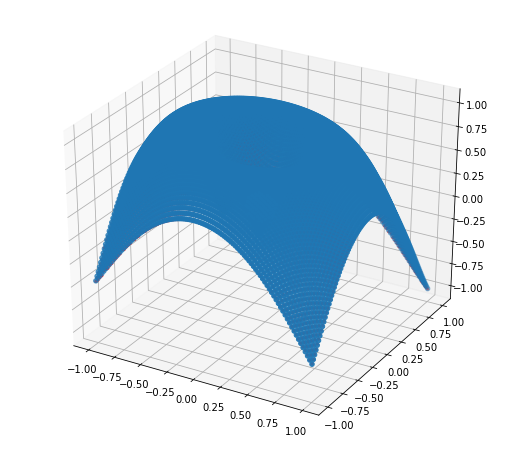

In [20]:
%matplotlib inline
fig = plt.figure(figsize=(9,8))
ax = fig.gca(projection='3d')
ax.scatter(X1, X2, Y)
ax.scatter(X1, X2, yout.data.reshape(Y.shape), color='r', marker='.')
plt.show()

## Create 2 Output layer
### create bilinear pair layer

In [375]:
class PairBilinear(nn.Module):
    def __init__(self, dim, grid_width):
        super().__init__()
        self.dim = dim
        self.grid_width = grid_width
        
        self.num_pairs = self.dim // 2
        along_row = torch.linspace(0, 1, self.grid_width).reshape(1, -1)
        along_col = torch.linspace(0, 1, self.grid_width).reshape(-1, 1)
        self.Y = torch.stack([along_row+along_col*0, along_row*0+along_col])
        self.Y = torch.repeat_interleave(self.Y.unsqueeze(0), self.num_pairs, dim=0)
        print(self.Y)
        print(self.Y.shape)
        self.Y = nn.Parameter(self.Y)
        
        self.pairW = torch.eye(2).unsqueeze(0).repeat_interleave(self.num_pairs, dim=0)
        print(self.pairW)
        
    
    def forward(self, x):
        bs = x.shape[0]
        x = x.view(-1, 2)
        
        ### perform pair wise matrix multiplication
        _gi = torch.arange(self.num_pairs).repeat(bs)
        print(_gi)
        _W = self.pairW[_gi]
        print(_W.shape)
        
        x = torch.bmm(x.unsqueeze(1), _W).squeeze(1)
        print(x.shape)
        
        x = x*self.grid_width
        index = torch.clamp(x.data, 0, self.grid_width-2)
        index = torch.floor(index)
        x = x-index
        
        print(index)
        index = (index.repeat_interleave(2, dim=0))
        print(index)
        
        
        _bi = torch.arange(bs).repeat_interleave(self.num_pairs*2)
        print(_bi)
        
        _gi = torch.arange(self.num_pairs).repeat_interleave(2).repeat(bs)
        print(_gi)
        _pi = torch.LongTensor([0,1]).repeat(bs*self.num_pairs)
        print(_pi) ## this is for selecting the 2 among pair
        
        _xc, _yc = tuple(index.type(torch.long).t())
        print(_xc)
        print(_yc)
#         f00, f01, f10, f11 = None

        f00 = self.Y[_gi, _pi, _xc, _yc]
        f01 = self.Y[_gi, _pi, _xc, _yc+1]
        f10 = self.Y[_gi, _pi, _xc+1, _yc]
        f11 = self.Y[_gi, _pi, _xc+1, _yc+1]
        
        print(f00, f01, f10, f11)
        
        a00 = f00
        a10 = f10-f00
        a01 = f01-f00
        a11 = f11-f10-f01+f00
        
        ##### this doubles the multiplication for x,y
#         x = x.repeat_interleave(2, dim=0)
#         print(x)
#         y = a00 + x[:, 0]*a10 + x[:, 1]*a01 + x[:, 0]*x[:, 1]*a11

        ##### this repeats in individual way
        print(x)
        _x, _y = x[:, 0].repeat_interleave(2), x[:, 1].repeat_interleave(2)
        y = a00 + _x*a10 + _y*a01 + _x*_y*a11
        
        ### now 
        y = y.view(bs, -1)
        print(y)
        pass

In [376]:
pb = PairBilinear(6, 5)

tensor([[[[0.0000, 0.2500, 0.5000, 0.7500, 1.0000],
          [0.0000, 0.2500, 0.5000, 0.7500, 1.0000],
          [0.0000, 0.2500, 0.5000, 0.7500, 1.0000],
          [0.0000, 0.2500, 0.5000, 0.7500, 1.0000],
          [0.0000, 0.2500, 0.5000, 0.7500, 1.0000]],

         [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.2500, 0.2500, 0.2500, 0.2500, 0.2500],
          [0.5000, 0.5000, 0.5000, 0.5000, 0.5000],
          [0.7500, 0.7500, 0.7500, 0.7500, 0.7500],
          [1.0000, 1.0000, 1.0000, 1.0000, 1.0000]]],


        [[[0.0000, 0.2500, 0.5000, 0.7500, 1.0000],
          [0.0000, 0.2500, 0.5000, 0.7500, 1.0000],
          [0.0000, 0.2500, 0.5000, 0.7500, 1.0000],
          [0.0000, 0.2500, 0.5000, 0.7500, 1.0000],
          [0.0000, 0.2500, 0.5000, 0.7500, 1.0000]],

         [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.2500, 0.2500, 0.2500, 0.2500, 0.2500],
          [0.5000, 0.5000, 0.5000, 0.5000, 0.5000],
          [0.7500, 0.7500, 0.7500, 0.7500, 0.7500],
    

In [379]:
pb(A)

tensor([0, 1, 2, 0, 1, 2])
torch.Size([6, 2, 2])
torch.Size([6, 2])
tensor([[3., 0.],
        [0., 1.],
        [3., 3.],
        [0., 3.],
        [3., 3.],
        [3., 0.]])
tensor([[3., 0.],
        [3., 0.],
        [0., 1.],
        [0., 1.],
        [3., 3.],
        [3., 3.],
        [0., 3.],
        [0., 3.],
        [3., 3.],
        [3., 3.],
        [3., 0.],
        [3., 0.]])
tensor([0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1])
tensor([0, 0, 1, 1, 2, 2, 0, 0, 1, 1, 2, 2])
tensor([0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1])
tensor([3, 3, 0, 0, 3, 3, 0, 0, 3, 3, 3, 3])
tensor([0, 0, 1, 1, 3, 3, 3, 3, 3, 3, 0, 0])
tensor([0.0000, 0.7500, 0.2500, 0.0000, 0.7500, 0.7500, 0.7500, 0.0000, 0.7500,
        0.7500, 0.0000, 0.7500], grad_fn=<IndexBackward>) tensor([0.2500, 0.7500, 0.5000, 0.0000, 1.0000, 0.7500, 1.0000, 0.0000, 1.0000,
        0.7500, 0.2500, 0.7500], grad_fn=<IndexBackward>) tensor([0.0000, 1.0000, 0.2500, 0.2500, 0.7500, 1.0000, 0.7500, 0.2500, 0.7500,
        1.0000, 0.0000, 1

In [175]:
# tensor([[0., 2., 2., 0.],
#         [0., 0., 1., 1.],
#         [3., 2., 3., 2.]])

NameError: name 'tensor' is not defined

In [378]:
A = torch.randn(2, 6)*0.5+0.5
A

tensor([[ 0.9798, -0.2690, -0.2305,  0.3082,  1.0783,  0.7317],
        [-0.1281,  1.0965,  0.7853,  1.9130,  0.7655, -0.2333]])

### Now cleaning the module and testing on 2D

In [411]:
class PairBilinear(nn.Module):
    def __init__(self, dim, grid_width):
        super().__init__()
        self.dim = dim
        self.grid_width = grid_width
        
        self.num_pairs = self.dim // 2
        along_row = torch.linspace(0, 1, self.grid_width).reshape(1, -1)
        along_col = torch.linspace(0, 1, self.grid_width).reshape(-1, 1)
        self.Y = torch.stack([along_row+along_col*0, along_row*0+along_col])
        self.Y = torch.repeat_interleave(self.Y.unsqueeze(0), self.num_pairs, dim=0)
        self.Y = nn.Parameter(self.Y)
        
        self.pairW = torch.eye(2).unsqueeze(0).repeat_interleave(self.num_pairs, dim=0)*0.5
        self.pairW = nn.Parameter(self.pairW)
    
    def forward(self, x):
        bs = x.shape[0]
        x = x.view(-1, 2)
        
        _wi = torch.arange(self.num_pairs).repeat(bs)
        _W = self.pairW[_wi]
        x = torch.bmm(x.unsqueeze(1), _W).squeeze(1)
        
        x = x*self.grid_width
        index = torch.clamp(x.data, 0, self.grid_width-2)
        index = torch.floor(index)
        x = x-index
        
        index = (index.repeat_interleave(2, dim=0))
        
        _bi = torch.arange(bs).repeat_interleave(self.num_pairs*2)
        _gi = torch.arange(self.num_pairs).repeat_interleave(2).repeat(bs)
        _pi = torch.LongTensor([0,1]).repeat(bs*self.num_pairs)
        _xc, _yc = tuple(index.type(torch.long).t())

        f00 = self.Y[_gi, _pi, _xc, _yc]
        f01 = self.Y[_gi, _pi, _xc, _yc+1]
        f10 = self.Y[_gi, _pi, _xc+1, _yc]
        f11 = self.Y[_gi, _pi, _xc+1, _yc+1]
        
        a00 = f00
        a10 = f10-f00
        a01 = f01-f00
        a11 = f11-f10-f01+f00
        
        ##### this doubles the multiplication for x,y
#         x = x.repeat_interleave(2, dim=0)
#         y = a00 + x[:, 0]*a10 + x[:, 1]*a01 + x[:, 0]*x[:, 1]*a11

        ##### this repeats in individual way
        _x, _y = x[:, 0].repeat_interleave(2), x[:, 1].repeat_interleave(2)
        y = a00 + _x*a10 + _y*a01 + _x*_y*a11

        ### now 
        y = y.view(bs, -1)
        return y

In [412]:
class BiasLayer(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.bias = nn.Parameter(torch.ones(dim)*1)
        
    def forward(self, x):
        return x+self.bias

In [413]:
pbil = PairBilinear(2, 10)

In [414]:
yout = pbil(torch.randn(10, 2))
yout.shape

torch.Size([10, 2])

In [469]:
model = nn.Sequential(
        BiasLayer(2),
        PairBilinear(2, 4),
        nn.Linear(2, 1)
                )

In [470]:
print(f"Parameters {sum([p.numel() for p in model.parameters()])}")

Parameters 41


In [471]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = nn.MSELoss()

In [472]:
%matplotlib tk
fig = plt.figure(figsize=(9,8))
ax = fig.gca(projection='3d')

hardness = 0
for epoch in range(10000):

    yout = model(xx)#[:, :1]
    loss = criterion(yout, yy)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if epoch%200 == 0:
#         fig = plt.figure(figsize=(9,8))
#         ax = fig.gca(projection='3d')

        error = float(loss)
        print(f'Epoch:{epoch} | Error:{error}')
        ax.clear()
        
        ax.scatter(X1, X2, Y)
        yout_ = yout.data.reshape(Y.shape)
        ax.scatter(X1, X2, yout_, color='r', marker='.')
        ax.set_xlabel('X1')
        ax.set_ylabel('X2')
        ax.set_zlabel('Y')
        
        fig.canvas.draw()
        plt.pause(0.01)
#         plt.show()

Epoch:0 | Error:0.6209641098976135
Epoch:200 | Error:0.04075885936617851
Epoch:400 | Error:0.03561197966337204
Epoch:600 | Error:0.03373963013291359
Epoch:800 | Error:0.0237728264182806
Epoch:1000 | Error:0.020252909511327744
Epoch:1200 | Error:0.020144805312156677
Epoch:1400 | Error:0.020130088552832603
Epoch:1600 | Error:0.020127175375819206
Epoch:1800 | Error:0.020125916227698326
Epoch:2000 | Error:0.020125627517700195
Epoch:2200 | Error:0.020125575363636017
Epoch:2400 | Error:0.020125798881053925
Epoch:2600 | Error:0.020134204998612404
Epoch:2800 | Error:0.0201261006295681
Epoch:3000 | Error:0.02013775147497654
Epoch:3200 | Error:0.02016306109726429


TclError: invalid command name "."

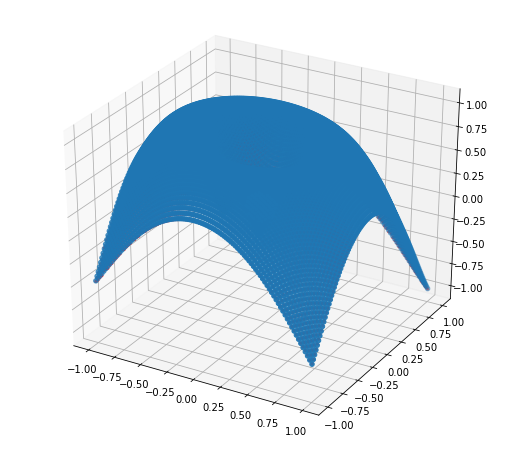

In [20]:
%matplotlib inline
fig = plt.figure(figsize=(9,8))
ax = fig.gca(projection='3d')
ax.scatter(X1, X2, Y)
ax.scatter(X1, X2, yout.data.reshape(Y.shape), color='r', marker='.')
plt.show()

In [454]:
def get_pair(inp_dim, step=1):
    dim = 2**int(np.ceil(np.log2(inp_dim)))
    assert isinstance(step, int), "Step must be integer"
    
    blocks = (2**step)
    range_ = dim//blocks
    adder_ = torch.arange(0, range_)*blocks
    
    pairs_ = torch.Tensor([0, blocks//2])
    repeat_ = torch.arange(0, blocks//2).reshape(-1,1)
    block_map = (pairs_+repeat_).reshape(-1)
    
    reorder_for_pair = (block_map+adder_.reshape(-1,1)).reshape(-1)
    indx = reorder_for_pair.type(torch.long)
    indx = indx[indx<inp_dim]
    
    rev_indx = torch.argsort(indx)
    return indx, rev_indx

In [456]:
get_pair(60, 3)

(tensor([ 0,  4,  1,  5,  2,  6,  3,  7,  8, 12,  9, 13, 10, 14, 11, 15, 16, 20,
         17, 21, 18, 22, 19, 23, 24, 28, 25, 29, 26, 30, 27, 31, 32, 36, 33, 37,
         34, 38, 35, 39, 40, 44, 41, 45, 42, 46, 43, 47, 48, 52, 49, 53, 50, 54,
         51, 55, 56, 57, 58, 59]),
 tensor([ 0,  2,  4,  6,  1,  3,  5,  7,  8, 10, 12, 14,  9, 11, 13, 15, 16, 18,
         20, 22, 17, 19, 21, 23, 24, 26, 28, 30, 25, 27, 29, 31, 32, 34, 36, 38,
         33, 35, 37, 39, 40, 42, 44, 46, 41, 43, 45, 47, 48, 50, 52, 54, 49, 51,
         53, 55, 56, 57, 58, 59]))

In [446]:
(tensor([0, 4, 1, 5, 2, 6, 3, 7]), tensor([0, 2, 4, 6, 1, 3, 5, 7]))
(tensor([0, 4, 1, 5, 2, 3]), tensor([0, 2, 4, 5, 1, 3]))

NameError: name 'tensor' is not defined

In [460]:
int(np.ceil(np.log2(8)))

3

In [490]:
class FactorizedPairBilinearSpline(nn.Module):
    
    def __init__(self, input_dim, grid_width):
        super().__init__()
        assert input_dim%2 == 0, "Input dim must be even number"
        self.input_dim = input_dim
        num_layers = int(np.ceil(np.log2(8)))
            
        self.facto_nets = []
        self.idx_revidx = []
        for i in range(num_layers):
            idrid = self.get_pair(self.input_dim, i+1)
            net = PairBilinear(self.input_dim, grid_width)
            self.facto_nets.append(net)
            self.idx_revidx.append(idrid)
        self.facto_nets = nn.ModuleList(self.facto_nets)
            
    def get_pair(self, inp_dim, step=1):
        dim = 2**int(np.ceil(np.log2(inp_dim)))
        assert isinstance(step, int), "Step must be integer"

        blocks = (2**step)
        range_ = dim//blocks
        adder_ = torch.arange(0, range_)*blocks

        pairs_ = torch.Tensor([0, blocks//2])
        repeat_ = torch.arange(0, blocks//2).reshape(-1,1)
        block_map = (pairs_+repeat_).reshape(-1)

        reorder_for_pair = (block_map+adder_.reshape(-1,1)).reshape(-1)
        indx = reorder_for_pair.type(torch.long)
        indx = indx[indx<inp_dim]

        rev_indx = torch.argsort(indx)
        return indx, rev_indx
    
    def forward(self, x):
        ## swap first and then forward and reverse-swap
        y = x
        for i in range(len(self.facto_nets)):
            idx, revidx = self.idx_revidx[i]
            y = y[:, idx]
            y = self.facto_nets[i](y) 
            y = y[:, revidx]
        y = x + y ## this is residual addition... remove if only want feed forward
        return y

In [491]:
fpbs = FactorizedPairBilinearSpline(6, 5)

In [492]:
param_count = sum([torch.numel(p) for p in fpbs.parameters()])
param_count

486

In [487]:
fpbs.idx_revidx

[(tensor([0, 1, 2, 3, 4, 5]), tensor([0, 1, 2, 3, 4, 5])),
 (tensor([0, 2, 1, 3, 4, 5]), tensor([0, 2, 1, 3, 4, 5])),
 (tensor([0, 4, 1, 5, 2, 3]), tensor([0, 2, 4, 5, 1, 3]))]

In [488]:
fpbs(torch.randn(3, 6))

tensor([[ 1.1777, -0.8325,  1.9054, -0.2675, -0.5369, -1.2561],
        [ 0.0810,  0.8081,  1.2820,  0.5139,  0.6325,  1.7155],
        [ 0.1840,  1.0194, -1.0283, -1.3535,  0.0659, -0.6539]],
       grad_fn=<AddBackward0>)